In [30]:
%load_ext autoreload
%autoreload 2
from src.models.representation.vae import *
from src.models.representation.vae.vae import RecurrentVaeWithTeacherForcing
from src.models.representation.vae.decoder.recurrent_decoder import *
from src.models.representation.vae.encoder.recurrent_encoder import *
from src.dataloader.dataset import PianoRollMidiDataset
pretty_int = lambda n: f"{n:,}".replace(",", " ")

def show_summary(model, input_shape=None, batch_size=None, dataset=None):
    """
    Show summary of the model.
    """
    print(model)
    p_count = sum(p.numel() for p in model.parameters())
    print(f"Model: {model.__class__.__name__}")
    
    print(f"Number of parameters: {pretty_int(p_count)}")
    print(f"Number of trainable parameters: {pretty_int(sum(p.numel() for p in model.parameters() if p.requires_grad))}")
    total_param_memory = sum(p.numel() * p.element_size() for p in model.parameters())
    print(f"Total parameter memory: {total_param_memory / (1024 ** 2):.2f} MB")
    if input_shape is not None:
        print(f"Input shape: {input_shape}")
    if batch_size is not None:
        print(f"Batch size: {batch_size}")
    if dataset is not None and input_shape is not None and batch_size is not None:
        print(f"Dataset size: {pretty_int(len(dataset))} samples")
        ratio = p_count / len(dataset)
        if p_count > len(dataset):
            print("Warning: Model has more parameters than samples in the dataset. This may lead to overfitting.")
        print(f"Parameter to sample ratio: {ratio:.2f}")
        


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pickle
from torchsummary import summary

import torch

dataset: PianoRollMidiDataset = pickle.load(open("data/preprocessed_note_events.pkl", "rb"))

print("Loaded dataset with", pretty_int(len(dataset)), "samples.")

Loaded dataset with 4 396 653 samples.


In [32]:
from torch.utils.data import DataLoader
from src.models.representation.vae.encoder.recurrent_encoder import LSTMVaeEncoderPitchEmbedding
from src.models.representation.vae.decoder.recurrent_decoder import LSTMVaeDecoderWithTeacherForcingPitchEmbedded
from src.models.representation.vae.decoder.mom_vae_decoder import MomVaeDecoder
import torch
from src.models.representation.vae.vae_loss import VaeLossWithCrossEntropy
import torch_optimizer

LATENT_DIM = 1_024 # sequence length of 4, so we have 16 dimensions per step 
EPOCHS = 50
ENC_HIDDEN_DIM = 16 * 4
DEC_HIDDEN_DIM = 16 * 4
DEC_FC_OUTPUT = 32
ENC_DEC_LAYERS = 4
RUN_NAME = f"test/vae_8_mom_beta_step0_01"


log_hyperparams = {
    "latent_dim": LATENT_DIM,
    "epochs": EPOCHS,
    "encoder_hidden_dim": ENC_HIDDEN_DIM,
    "decoder_hidden_dim": DEC_HIDDEN_DIM,
    "run_name": RUN_NAME,
}


encoder = LSTMVaeEncoderPitchEmbedding(
    4,
    ENC_HIDDEN_DIM,
    LATENT_DIM,
    ENC_DEC_LAYERS,
    linear_scaling_dim=4*3,
    pitch_embedding_dim=4,
    dropout=0.5,
)
decoder = MomVaeDecoder(
    LATENT_DIM, 
    DEC_HIDDEN_DIM,
    DEC_FC_OUTPUT,
    ENC_DEC_LAYERS,
    teacher_forcing_ratio=0.6,
    teacher_forcing_decrease=0.05
)

vae = RecurrentVaeWithTeacherForcing(encoder, decoder).cuda()

MAX_DELTA_TIME = 2 
MIN_NOTE_DURATION = 0.1
SEQUENCE_LENGTH = 4

def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences in the batch.
    """
    batch = torch.stack(batch, dim=0)
    # batch = batch[:,:SEQUENCE_LENGTH,:]
    batch[:, :, 2:] = batch[:, :, 2:].clamp(min=MIN_NOTE_DURATION, max=MAX_DELTA_TIME)
    return batch

midi_dataloader = DataLoader(
    dataset,
    batch_size=4096,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn
)


optimizer = torch_optimizer.Lamb(
    vae.parameters(),
    lr=1e-3,
    weight_decay=1e-4,
)

loss_fn = VaeLossWithCrossEntropy(
    reduction="mean",
    beta_max=1,
    beta_step=0.01,
)

trainer = VaeTrainer(
    vae,
    optimizer,
    loss_fn,
    RUN_NAME,
    40
)

t = next(iter(midi_dataloader))
show_summary(vae, input_shape=t[0].shape, batch_size=t.shape[0], dataset=dataset)


trainer.log_model_hyperparameters(log_hyperparams)
# trainer.graph_model(t.cuda())
with torch.no_grad():
    t_out = vae(t.cuda())
# print(f"Output shape: {t_out[0].shape}, {t_out[1].shape}")

RecurrentVaeWithTeacherForcing(
  (encoder): LSTMVaeEncoderPitchEmbedding(
    (linear): Linear(in_features=3, out_features=12, bias=True)
    (pitch_embedding): Embedding(128, 4)
    (lstm): LSTM(16, 64, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
    (mu_linear): Linear(in_features=128, out_features=1024, bias=True)
    (logvar_linear): Linear(in_features=128, out_features=1024, bias=True)
  )
  (decoder): MomVaeDecoder(
    (lstm): LSTM(131, 64, num_layers=32, batch_first=True)
    (latent_to_hidden): Linear(in_features=1024, out_features=64, bias=True)
    (latent_to_cell): Linear(in_features=1024, out_features=64, bias=True)
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
    (pitch_linear): Linear(in_features=4, out_features=128, bias=True)
    (other_scaling): Linear(in_features=4, out_features=3, bias=True)
    (mom): MemoryOverwriteModule(
      (forget_gate): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
     

In [33]:
ep = (t[2] * torch.tensor([1, 127, 1, 1]))

print(ep[0][0:2].long())

print("TIME ")
print(ep[0][2:])


tensor([72, 60])
TIME 
tensor([0.1000, 0.7487])


In [34]:
trainer.train(midi_dataloader, epochs=EPOCHS)


  0%|          | 0/50 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [35]:
# trainer.save_model(f"models/")
trainer.load_model(f"models/{RUN_NAME}.pth")

Loading model from models/test/vae_8_mom_beta_step0_01.pth
Model loaded from models/test/vae_8_mom_beta_step0_01.pth


100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


Converting 5 latent samples to numpy array.
Converting latent samples to numpy array for PCA. Shape: (20480, 1024)


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'PCA of Latent Space'}, xlabel='Principal Component 1', ylabel='Principal Component 2'>)

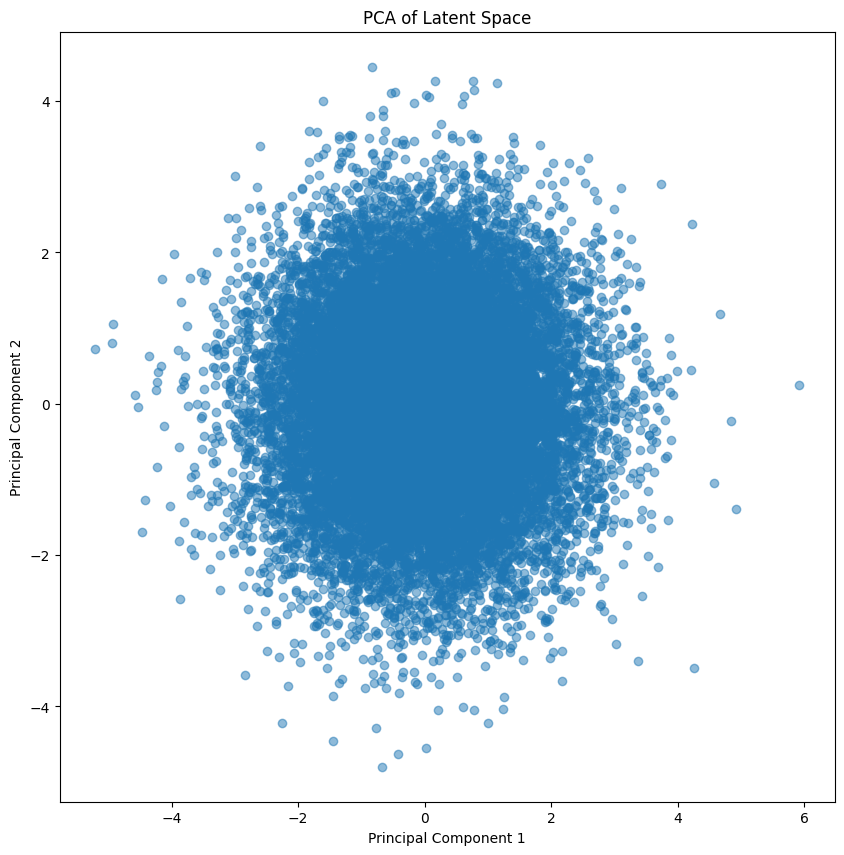

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.common.diagnostic.latent.latent_visualization import plot_pca


def disable_teacher_forcing(vae ):
    """
    Disable teacher forcing in the VAE model.
    """
    vae.decoder.teacher_forcing_ratio = 0
    vae.decoder.teacher_forcing_decrease = 0


disable_teacher_forcing(vae)


eg_samples = []
for i in tqdm(range(5)):
    t = next(iter(midi_dataloader))
    latents = vae.encode_with_reparameterization(t.cuda())
    eg_samples.append(latents)

    
plot_pca(eg_samples)

In [43]:
import pretty_midi

noise = torch.randn(1, LATENT_DIM).cuda()

@torch.inference_mode
def sampler(noise, sqe_length, vae: RecurrentVae):
    """
    Sample from the VAE using the provided noise.
    """
    vae.eval()
    if getattr(vae.decoder, "teacher_forcing_ratio") is not None:
        vae.decoder.teacher_forcing_ratio = 0.0
    # Encode the noise
    # Decode to get the generated sequence
    d = vae.decoder(noise, seq_length=sqe_length)
    pitches_one_hot, others = d
    pitches = (torch.argmax(pitches_one_hot, dim=-1)).unsqueeze(-1)
    generated_sequence = torch.cat([pitches, others], dim=-1)
    return generated_sequence


    

eg_track = sampler(noise, 32, vae)


In [44]:
def print_track_stats(track: torch.Tensor):
    """
    Print statistics of the track.
    """
    print(f"Track Shape: {track.shape}")
    pitches = track[:, 0].cpu().numpy()
    velocities = track[:, 1].cpu().numpy()
    time = track[:, 2].cpu().numpy()
    duration = track[:, 3].cpu().numpy()
    # pitches = pitches*127  # Scale pitches
    velocities = velocities*127  # Scale velocities
    print(f"Track Length: {len(track)}")
    print(f"Unique Pitches: {np.unique(pitches).size}")
    print(f"Unique Velocities: {np.unique(velocities).size}")
    print(f"max Pitch: {np.max(pitches)}")
    print(f"min Pitch: {np.min(pitches)}")
    print(f"max Velocity: {np.max(velocities)}")
    print(f"min Velocity: {np.min(velocities)}")
    print(f"Mean Pitch: {np.mean(pitches)}")
    print(f"Mean Velocity: {np.mean(velocities)}")
    duration_total = 0
    for i in range(1, len(duration)):
        duration_total += time[i] + duration[i]
    print(f"Total Duration: {duration_total}")
    


print_track_stats(eg_track[0])


Track Shape: torch.Size([32, 4])
Track Length: 32
Unique Pitches: 10
Unique Velocities: 32
max Pitch: 85.0
min Pitch: 40.0
max Velocity: 73.94711303710938
min Velocity: 60.64475631713867
Mean Pitch: 72.40625
Mean Velocity: 68.43356323242188
Total Duration: 26.060144424438477


In [45]:
print_track_stats(t[0])

Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 8
Unique Velocities: 7
max Pitch: 85.0
min Pitch: 49.0
max Velocity: 86.0
min Velocity: 48.0
Mean Pitch: 70.625
Mean Velocity: 63.875
Total Duration: 6.3020830154418945


In [48]:
import pretty_midi

@torch.inference_mode
def note_events_to_pretty_midi(note_array, path="eg.mid", default_program=0):
    note_array = note_array.detach().cpu().numpy()
    #scale  and velocities
    note_array[:, 1] *= 127
    # clamp pitches and velocities
    note_array[:, 0] = np.clip(note_array[:, 0], 0, 127)
    note_array[:, 1] = np.clip(note_array[:, 1], 0, 127)
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=default_program)

    current_time = 0.0
    print(note_array.shape)
    for row in note_array:
        pitch, velocity, delta, duration = row
        current_time += delta
        start = current_time
        end = start + duration

        note = pretty_midi.Note(
            velocity=int(velocity),
            pitch=int(pitch),
            start=start,
            end=end
        )
        instrument.notes.append(note)

    pm.instruments.append(instrument)
    pm.write(path)


note_events_to_pretty_midi(eg_track[0], path="eg.mid")

(32, 4)


In [50]:
from src.common.diagnostic.misc import vae_adapter


track_reco = vae_adapter(t[0].unsqueeze(0), vae)
note_events_to_pretty_midi(track_reco[0], path="reco.mid")

(8, 4)


In [51]:
track_true = t[0]
note_events_to_pretty_midi(track_true, path="true.mid")

(8, 4)


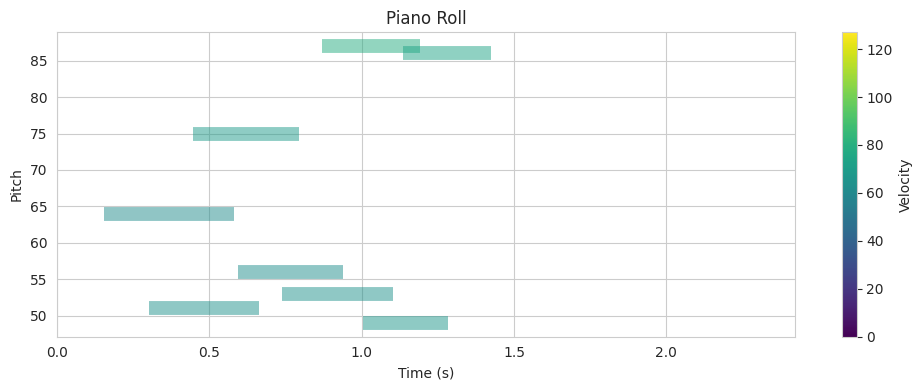

(8, 4)


In [57]:
from matplotlib import cm
from matplotlib import colors as mcolors
import seaborn as sns

from src.common.diagnostic.visualize_note_events import plot_piano_roll_from_note_events
sns.set_style("whitegrid")


noise = torch.randn(1, LATENT_DIM).cuda()
eg_track = sampler(noise, 8, vae)
plot_piano_roll_from_note_events(eg_track[0].detach().cpu().numpy())
note_events_to_pretty_midi(eg_track[0], path="eg_track.mid")

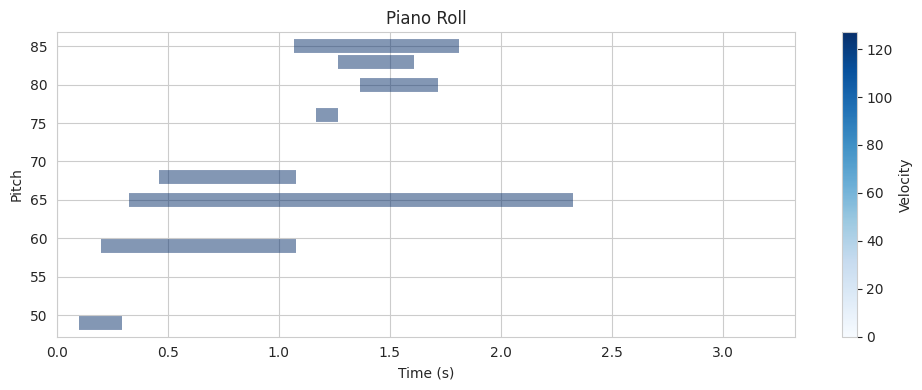

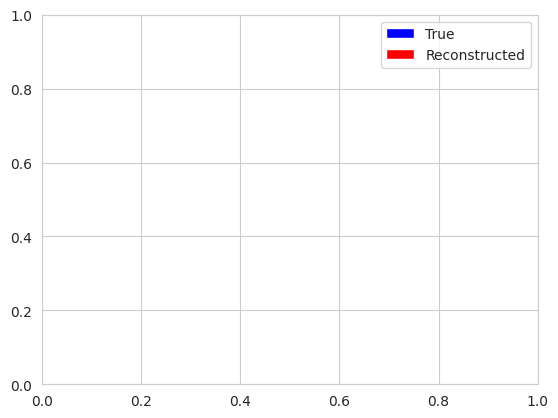

In [61]:


from src.common.diagnostic.visualize_note_events import compare_reco_true


compare_reco_true(
    track_true,
    track_reco.squeeze(0).detach().cpu().numpy(),
    figsize=(10, 4)
)



In [62]:
track_reco

tensor([[[49.0000,  0.5085,  0.1636,  0.4581],
         [59.0000,  0.4867,  0.1707,  0.5070],
         [65.0000,  0.4792,  0.1809,  0.6415],
         [68.0000,  0.4804,  0.1851,  0.6269],
         [85.0000,  0.5731,  0.1739,  0.6425],
         [76.0000,  0.4842,  0.1903,  0.6749],
         [83.0000,  0.5442,  0.1867,  0.7224],
         [80.0000,  0.5647,  0.1880,  0.7760]]], device='cuda:0')

In [66]:

example_for_reco = next(iter(midi_dataloader))[0].cuda()

def disable_teacher_forcing(vae: RecurrentVaeWithTeacherForcing):
    """
    Disable teacher forcing in the VAE.
    """
    vae.decoder.teacher_forcing_ratio = 0.0

disable_teacher_forcing(vae)



reco_track = vae_adapter(example_for_reco.unsqueeze(0), vae).squeeze(0)
print("----------")
print("Reconstructed Track Stats:")
print_track_stats(reco_track)
print("----------")
print("True Track Stats:")
print_track_stats(example_for_reco)


----------
Reconstructed Track Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 7
Unique Velocities: 8
max Pitch: 84.0
min Pitch: 56.0
max Velocity: 75.71121215820312
min Velocity: 63.67099380493164
Mean Pitch: 76.0
Mean Velocity: 69.53347778320312
Total Duration: 3.4131247997283936
----------
True Track Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 7
Unique Velocities: 8
max Pitch: 84.0
min Pitch: 56.0
max Velocity: 68.0
min Velocity: 35.0
Mean Pitch: 76.0
Mean Velocity: 51.125
Total Duration: 3.4502604007720947


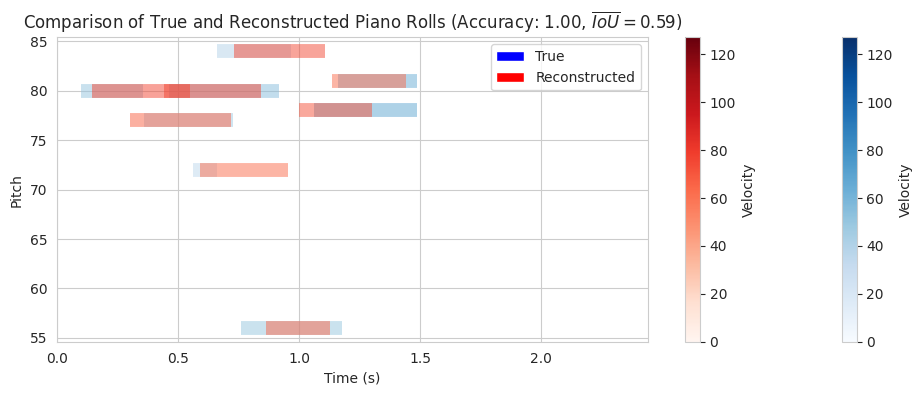

In [75]:
compare_reco_true(example_for_reco.detach().cpu().numpy(), reco_track, figsize=(10, 4))

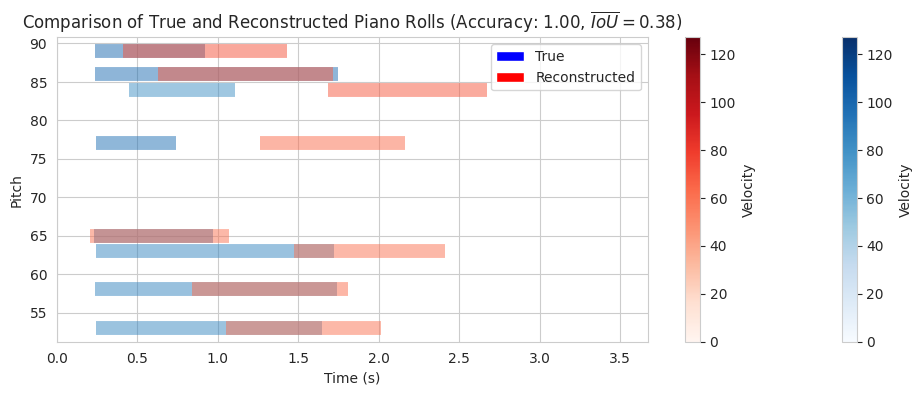

In [85]:

@torch.inference_mode
def get_random_pair(vae, dataloader, strip_to_seq_length=None):
    dataset = dataloader.dataset
    idx = np.random.randint(0, len(dataset), size=2)
        
    first_sample = dataset[idx[0]]
    reconstructed_sample = vae_adapter(first_sample.unsqueeze(0), vae).squeeze(0)
    if strip_to_seq_length is not None:
        first_sample = first_sample[:strip_to_seq_length, :]
        reconstructed_sample = reconstructed_sample[:strip_to_seq_length, :]
    
    return first_sample, reconstructed_sample.detach().cpu().numpy()


compare_reco_true(*get_random_pair(vae, midi_dataloader, strip_to_seq_length=8), figsize=(10, 4))

In [86]:
def get_by_idx(dataloader, idx):
    """
    Get a sample from the dataloader by index.
    """
    for i, batch in enumerate(dataloader):
        if i == idx:
            return batch


tracks = get_by_idx(midi_dataloader, 0)
print(f"Number of tracks: {tracks.shape[0]}")
for i,t in enumerate(tracks):
    print("----------")
    print(f"Track {i+1} Stats:")
    print_track_stats(t)

Number of tracks: 4096
----------
Track 1 Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 4
Unique Velocities: 7
max Pitch: 81.0
min Pitch: 48.0
max Velocity: 61.0
min Velocity: 46.0
Mean Pitch: 71.75
Mean Velocity: 53.375
Total Duration: 2.015625
----------
Track 2 Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 8
Unique Velocities: 8
max Pitch: 85.0
min Pitch: 36.0
max Velocity: 112.0
min Velocity: 83.0
Mean Pitch: 68.5
Mean Velocity: 100.75
Total Duration: 3.7609376907348633
----------
Track 3 Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 4
Unique Velocities: 8
max Pitch: 79.0
min Pitch: 67.0
max Velocity: 81.0
min Velocity: 20.0
Mean Pitch: 70.375
Mean Velocity: 53.625
Total Duration: 3.721874952316284
----------
Track 4 Stats:
Track Shape: torch.Size([8, 4])
Track Length: 8
Unique Pitches: 7
Unique Velocities: 8
max Pitch: 81.0
min Pitch: 58.0
max Velocity: 96.0
min Velocity: 67.0
Mean Pitch: 73.0
Mean Velocity

In [87]:
eg_batch = next(iter(midi_dataloader)).cuda()
print(f"Batch shape: {eg_batch.shape}")

target = eg_batch[:, :, 0].long().cuda()
print(f"Target shape: {target.shape}")

ce_loss_fn = torch.nn.CrossEntropyLoss(reduction='none')



Batch shape: torch.Size([4096, 8, 4])
Target shape: torch.Size([4096, 8])


In [92]:
def interpolate_latents(vae, noise1, noise2, steps=10, seq_length=16):
    vae.eval()
    if getattr(vae.decoder, "teacher_forcing_ratio") is not None:
        vae.decoder.teacher_forcing_ratio = 0.0

    decoded = []
    noise1 = noise1.cuda()
    noise2 = noise2.cuda()
    for i in range(steps):
        alpha = i / (steps - 1)
        noise = noise1 * (1 - alpha) + noise2 * alpha
        track = sampler(noise, seq_length, vae)
        decoded.append(track)
    return decoded



def plot_interpolated_tracks(vae, latent_1, latent_2, steps=10, figsize=(10, 4), seq_len=8):

    events = interpolate_latents(vae, latent_1, latent_2, steps=steps, seq_length=seq_len)
    fig, axs = plt.subplots(len(events), 1, figsize=figsize, sharex=True, sharey=True)
    
    for ax, event in zip(axs, events):
        plot_piano_roll_from_note_events(event[0].detach().cpu().numpy(), figsize=figsize, fig=fig, ax=ax, cmap='Blues', show_colorbar=False)
        ax.set_title(f"Step {len(axs) - np.where(axs == ax)[0][0] - 1}")
    plt.suptitle("Interpolated Tracks")
    
    

    plt.tight_layout()
    plt.show()


@torch.inference_mode
def get_best_reconstruction(vae, dataloader):
    best_reco = None
    best_latent = None
    best_loss = float('inf')
    loss_in_fn = VaeLossWithCrossEntropy(reduction="mean", beta=1)
    for x in tqdm(dataloader, desc="Finding best reconstruction"):
        x = x.cuda()
        reco, mu, logvar = vae(x)
        loss = loss_in_fn(reco, x, mu, logvar)[0]
        if loss < best_loss:
            best_loss = loss
            best_reco = reco
            best_latent = vae.encoder(x)[0]
            
    print(f"Best reconstruction loss: {best_loss.item()}")
    return best_reco, best_latent

noise1 = torch.randn(1, LATENT_DIM).cuda()
noise2 = torch.randn(1, LATENT_DIM).cuda()



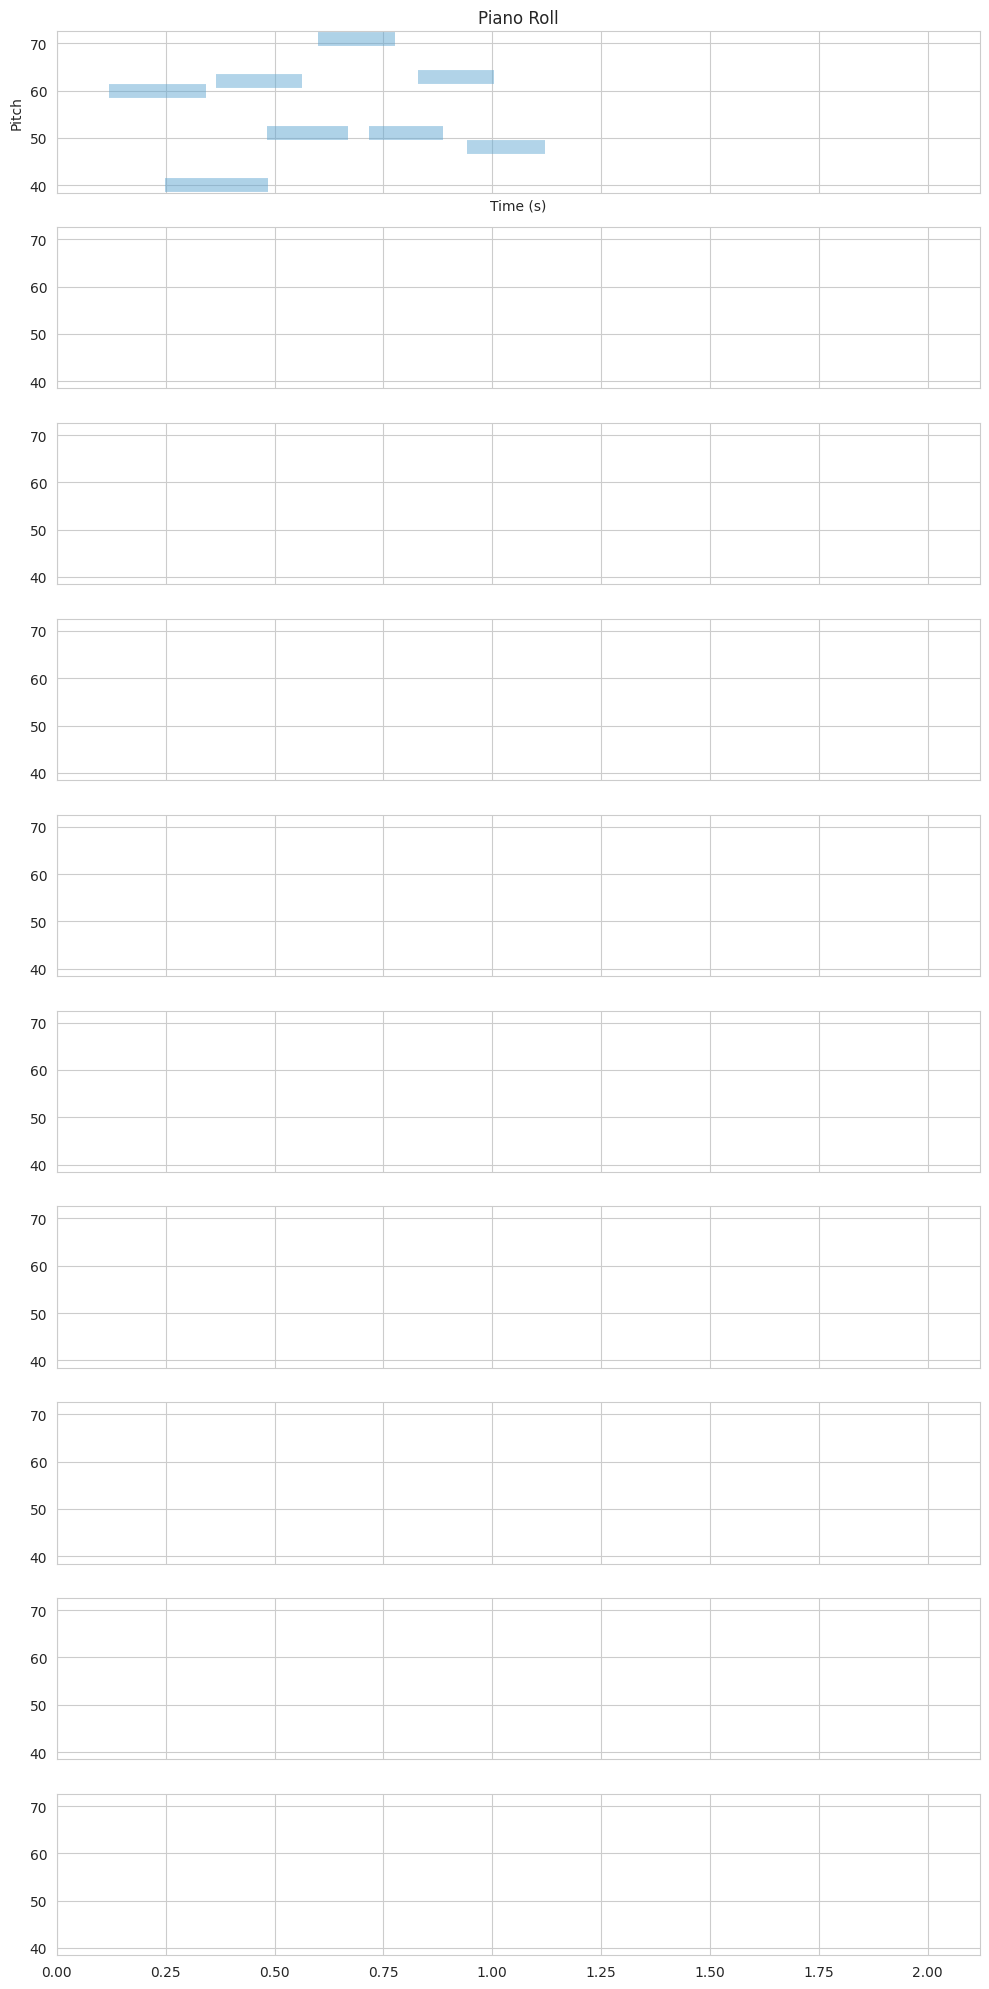

<Figure size 640x480 with 0 Axes>

In [93]:
plot_interpolated_tracks(vae, noise2, noise1, steps=10, figsize=(10, 20))

Representation rank: 1024


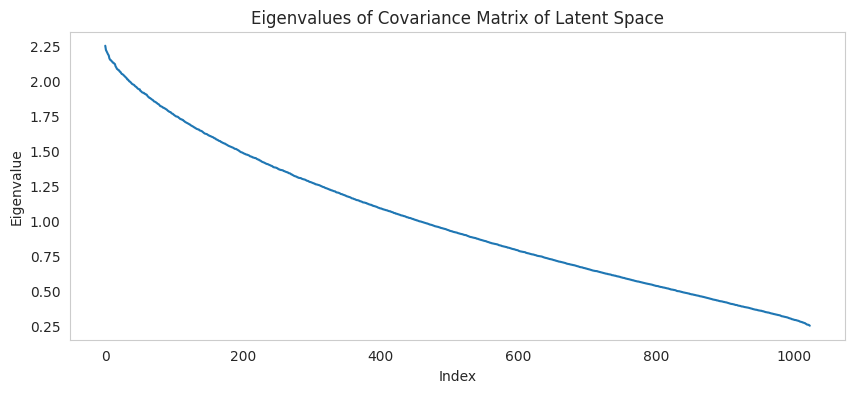

tensor(1024, device='cuda:0')

In [94]:

@torch.inference_mode
def compute_cov_eig(z: torch.Tensor) -> torch.Tensor:
    z_centered = z - z.mean(dim=0, keepdim=True)
    samples = z.size(0) - 1
    covaraiance_matrix = (z_centered.T @ z_centered) / samples
    eigenvalues = torch.linalg.eigvalsh(covaraiance_matrix)
    
    sorted_eigenvalues = torch.sort(eigenvalues, descending=True).values
    return sorted_eigenvalues

def plot_cov_eigenvalues(z: torch.Tensor, figsize=(10, 4)):
    """
    Plot the eigenvalues of the covariance matrix of the latent space.
    """
    eigenvalues = compute_cov_eig(z)
    
    plt.figure(figsize=figsize)
    plt.plot(eigenvalues.cpu().numpy(), marker='o', linestyle='-',  markersize=0.01)
    plt.title("Eigenvalues of Covariance Matrix of Latent Space")
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue")
    plt.grid()
    plt.show()


@torch.inference_mode
def get_representation_rank(data, vae):
    """
    Get the rank of the representation by sampling from the latent space.
    """
    vae.eval()
    if getattr(vae.decoder, "teacher_forcing_ratio") is not None:
        vae.decoder.teacher_forcing_ratio = 0.0

    mu, logvar = vae.encoder(data.cuda())
    reparam = mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)

    rank = torch.linalg.matrix_rank(reparam)
    print(f"Representation rank: {rank}")
    plot_cov_eigenvalues(reparam, figsize=(10, 4))
    return rank


eg_batch = next(iter(midi_dataloader)).cuda()
get_representation_rank(eg_batch, vae)
    



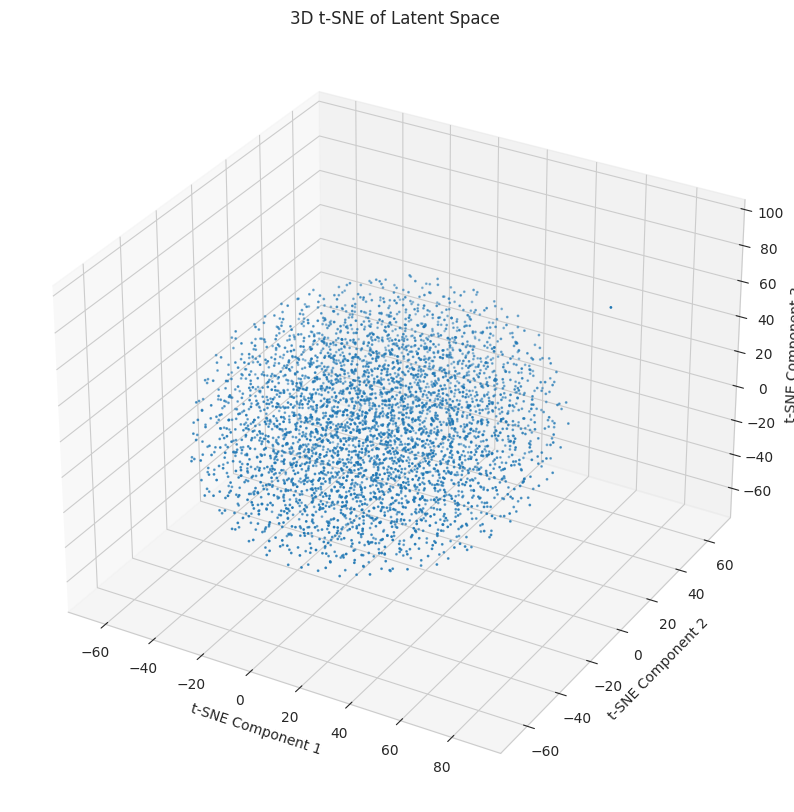

In [95]:
from sklearn.manifold import TSNE

@torch.inference_mode
def plot_tsne(vae, eg_batch: torch.Tensor, labels=None, figsize=(10, 4)):
    """
    Plot t-SNE of the latent space.
    """
    vae.eval()
    mu, logvar = vae.encoder(eg_batch.cuda())
    reparam = mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
    z = reparam
    z_np = z.cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(z_np)

    plt.figure(figsize=figsize)
    if labels is not None:
        plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels, cmap='viridis', s=1)
        plt.colorbar(label='Labels')
    else:
        plt.scatter(z_tsne[:, 0], z_tsne[:, 1], s=1)
    
    plt.title("t-SNE of Latent Space")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid()
    plt.show()

@torch.inference_mode
def plot_3dim_tsne(vae, eg_batch: torch.Tensor, labels=None, figsize=(10, 4)):
    """
    Plot 3D t-SNE of the latent space.
    """
    from mpl_toolkits.mplot3d import Axes3D
    from sklearn.manifold import TSNE

    vae.eval()
    mu, logvar = vae.encoder(eg_batch.cuda())
    reparam = mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
    z = reparam
    z_np = z.cpu().numpy()
    
    tsne = TSNE(n_components=3, random_state=42)
    z_tsne = tsne.fit_transform(z_np)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z_tsne[:, 0], z_tsne[:, 1], z_tsne[:, 2], s=1)
    
    ax.set_title("3D t-SNE of Latent Space")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.set_zlabel("t-SNE Component 3")
    plt.show()

plot_3dim_tsne(vae, eg_batch, figsize=(10, 4))

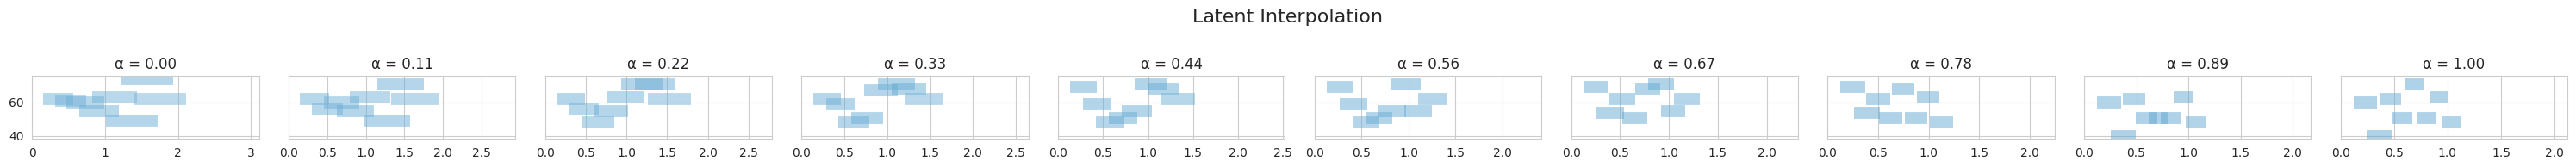

In [98]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def interpolate_latents_plug(vae, noise1, noise2, steps=10, seq_length=16, device='cuda'):
    """
    Linearly interpolates between two latent vectors in latent space and decodes each step using the VAE.
    
    Args:
        vae: The VAE model.
        noise1, noise2: Latent vectors (torch.Tensor).
        steps: Number of interpolation steps.
        seq_length: Output sequence length.
        device: Device to run on ('cuda' or 'cpu').

    Returns:
        List of decoded outputs.
    """
    vae.eval()
    if getattr(vae.decoder, "teacher_forcing_ratio", None) is not None:
        vae.decoder.teacher_forcing_ratio = 0.0

    noise1 = noise1.to(device)
    noise2 = noise2.to(device)

    decoded = []
    for i in range(steps):
        alpha = i / (steps - 1)
        interpolated = (1 - alpha) * noise1 + alpha * noise2
        track = sampler(interpolated, seq_length, vae)
        decoded.append(track)
    return decoded

def plot_interpolated_tracks_plug(vae, latent_1, latent_2, steps=10, seq_len=8, figsize=(12, 2), cmap='Blues'):
    """
    Plots a horizontal row of piano roll visualizations for each interpolation step.

    Args:
        vae: The VAE model.
        latent_1, latent_2: Latent vectors to interpolate between.
        steps: Number of steps in interpolation.
        seq_len: Sequence length for decoding.
        figsize: Tuple size for individual subplots.
        cmap: Color map for piano roll.
    """
    events = interpolate_latents(vae, latent_1, latent_2, steps=steps, seq_length=seq_len)
    
    fig, axs = plt.subplots(1, steps, figsize=(figsize[0] * steps // 4, figsize[1]), sharey=True)
    
    if steps == 1:
        axs = [axs]  # Ensure iterable

    for i, (ax, event) in enumerate(zip(axs, events)):
        piano_roll = event[0].detach().cpu().numpy()
        plot_piano_roll_from_note_events(
            piano_roll, 
            ax=ax, 
            cmap=cmap, 
            show_colorbar=False, 
            show=False,
            figsize=figsize,
            fig=fig
        )
        ax.set_title(f"α = {i/(steps-1):.2f}")
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.suptitle("Latent Interpolation", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_interpolated_tracks_plug(vae, noise1, noise2, steps=10, seq_len=8, figsize=(12, 2), cmap='Blues')

Generated random walk sample shape: torch.Size([80, 4])


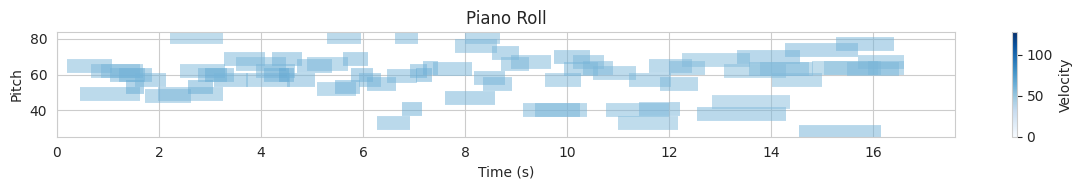

(80, 4)


In [103]:
@torch.inference_mode
def random_walk_sampler(vae, steps=10, seq_length=8, noise_scale=0.1, device='cuda'):
    """
    Generates a sequence where each step is a random walk in the latent space of the VAE.
    Markov chain sampling method.
    Args:
        vae: The VAE model.
        steps: Number of steps in the random walk.
        seq_length: Output sequence length.
        noise_scale: Scale of noise added at each step.
        device: Device to run on ('cuda' or 'cpu').
    """
    vae.eval()
    if getattr(vae.decoder, "teacher_forcing_ratio", None) is not None:
        vae.decoder.teacher_forcing_ratio = 0.0

    latent_dim = LATENT_DIM
    noise = torch.randn(1, latent_dim).to(device)
    
    decoded = []
    for _ in range(steps):
        noise += torch.randn_like(noise) * noise_scale
        track = sampler(noise, seq_length, vae)
        decoded.append(track.squeeze(0))
    
    return torch.cat(decoded, dim=0)


walk_sample = random_walk_sampler(vae, steps=10, seq_length=8, noise_scale=0.5, device='cuda')
print(f"Generated random walk sample shape: {walk_sample.shape}")

plot_piano_roll_from_note_events(walk_sample.detach().cpu().numpy(), figsize=(12, 2), cmap='Blues')

note_events_to_pretty_midi(walk_sample, path="random_walk_sample.mid")

torch.Size([800, 4])
(800, 4)


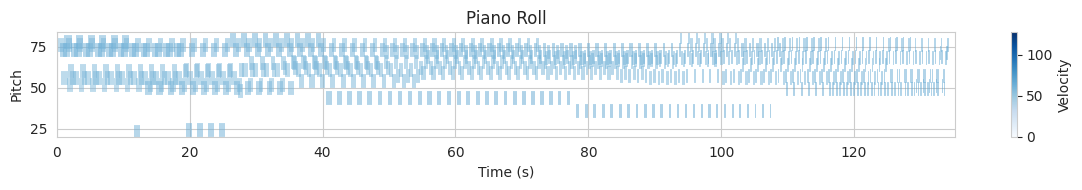

(<Figure size 1200x200 with 2 Axes>,
 <Axes: title={'center': 'Piano Roll'}, xlabel='Time (s)', ylabel='Pitch'>)

In [128]:


@torch.inference_mode
def interpolate_sampler(noise1, noise2, vae: RecurrentVaeWithTeacherForcing, steps=10, seq_length=8, ):
    """
    Interpolates between two latent vectors in the VAE's latent space.
    """
    vae.eval()
    if getattr(vae.decoder, "teacher_forcing_ratio", None) is not None:
        vae.decoder.teacher_forcing_ratio = 0.0

    decoded = []
    noise1 = noise1.cuda()
    noise2 = noise2.cuda()
    
    for i in range(steps):
        alpha = i / (steps - 1)
        noise = noise1 * (1 - alpha) + noise2 * alpha
        track = sampler(noise, seq_length, vae)
        decoded.append(track)
    
    return torch.cat(decoded, dim=1).squeeze(0)

noise1 = torch.randn(1, LATENT_DIM).cuda()
noise2 = torch.randn(1, LATENT_DIM).cuda()
noise = interpolate_sampler(noise1, noise2, steps=100, seq_length=8, vae=vae)
print(noise.shape)
note_events_to_pretty_midi(noise, path="interpolated_sample.mid")
plot_piano_roll_from_note_events(noise.detach().cpu().numpy(), figsize=(12, 2), cmap='Blues')


In [125]:
note_events_to_pretty_midi(noise, path="interpolated_sample_guitar.mid", default_program=33)


(800, 4)
